# Time series forecasting with DeepAR - Synthetic data

DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference.

This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

In [5]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
np.random.seed(1)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Let's start by specifying:
- The S3 bucket prefix that you want to use for training and model data. Here we use the default bucket with `sagemaker_session.default_bucket()`, but you can change this to a bucket of your choosing. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [6]:
PREFIX = "sagemaker/DEMO-deepar-orig"

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

s3_data_path = f"{bucket}/{PREFIX}/data"
s3_output_path = f"{bucket}/{PREFIX}/output"

print(f's3_data_path: {s3_data_path}')
print(f's3_output_path: {s3_output_path}')

s3_data_path: sagemaker-us-east-1-850441823857/sagemaker/DEMO-deepar-orig/data
s3_output_path: sagemaker-us-east-1-850441823857/sagemaker/DEMO-deepar-orig/output


Next, we configure the container image to be used for the region that we are running in.

In [7]:
from sagemaker.image_uris import retrieve

DEEPAR_FRAMEWORK = "forecasting-deepar"
image_uri = retrieve(DEEPAR_FRAMEWORK, region, sagemaker_session=sagemaker_session)
print(f'{DEEPAR_FRAMEWORK} image_uri: {image_uri}')

forecasting-deepar image_uri: 522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1


### Generating and uploading data

In this example we want to train a model that can predict the next points of syntheticly generated time series.
The time series that we use have hourly granularity.


We also need to configure the so-called `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`. In our example we will use a longer `context_length` of `2 days`. Note that in addition to the `context_length` the model also takes into account the values of the time series at typical seasonal windows e.g. for hourly data the model will look at the value of the series 24h ago, one week ago one month ago etc. So it is not necessary to make the `context_length` span an entire month if you expect monthly seasonalities in your hourly data.

For this notebook, we will generate noisy time series, each consisting of 2 weeks data points and with seasonality of 24 hours. In our dummy example, all time series start at the same time point `START_TS`. When preparing your data, it is important to use the correct start point for each time series, because the model uses the time-point as a frame of reference, which enables it to learn e.g. that weekdays behave differently from weekends.


In [8]:
FREQ = "H"
DAY = 24 # hours in a day
prediction_length = DAY
context_length = DAY
TOTAL_DYAS = 14
data_length = TOTAL_DYAS * DAY
START_TS = "2016-01-01 00:00:00"
NUMBER_OF_TS = 200

Each time series will be a noisy combined sine and cosine signal with a random level. That will be the target value of the time series.
Each time series is associated to a specific static category value (1,2,3). Each category produces a unique target signal.
Each time series target value is also affected by a dynamic feature that is changes over time.

/tmp/ipykernel_28/2233096342.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=START_TS, freq=FREQ, periods=data_length)


df.shape: (168, 3)
                       target  dynamic_feat  cat
2016-01-14 19:00:00 -1.268324     -0.772741  100
2016-01-14 20:00:00 -1.266912     -0.400000  100
2016-01-14 21:00:00 -0.802221      0.207055  100
2016-01-14 22:00:00 -0.180568      0.692820  100
2016-01-14 23:00:00  0.290587      0.772741  100


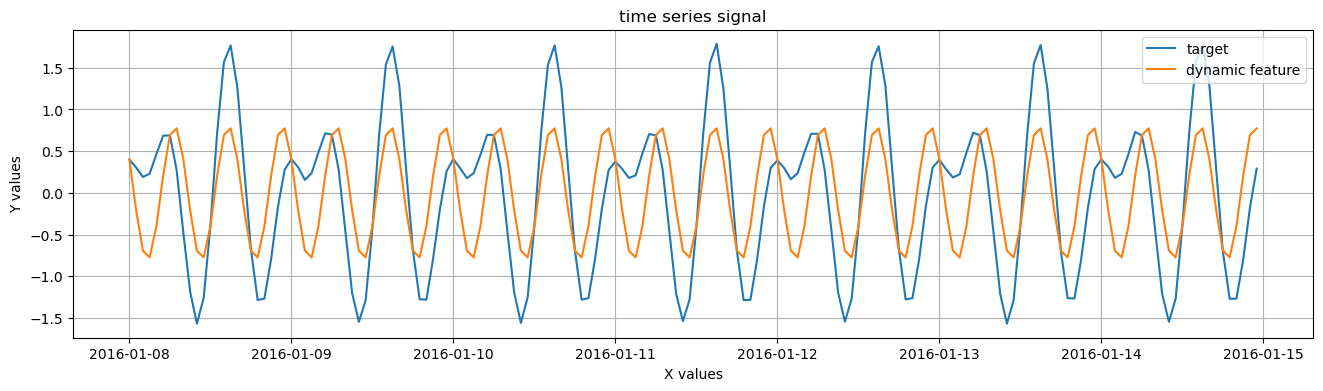

In [9]:
# static categories
categories_df = pd.DataFrame({
    "color": ['green', 'blue', 'red'], 
    "freq_sin": [1.0, 2.0, 5.0],
    "freq_cos": [1.0, 3.0, 2.0]
})

# util to return the static category data based on a (regulated) time series index
def get_cat_df(idx: int)-> pd.DataFrame:   
    return categories_df.iloc[idx % len(categories_df)]

# util to generate a time series data frame (based on a given static category)
def synth_time_series(idx: int) -> pd.DataFrame: 
    # play with these values to generate interesting signal     
    SIN_AMPLITUDE = 1.0
    SIN_PHASE_SHIFT = 0
    COS_AMPLITUDE = 0.8
    COS_SHIFT_COS = np.pi/3

    # get static categorical data
    cat_df = get_cat_df(idx)    
    frequency_sin = cat_df["freq_sin"]
    frequency_cos = cat_df["freq_cos"]
    
    # generate X values
    x = np.arange(0, data_length)
    # generate random noise    
    level = 10 * np.random.rand()
    noise = 0.003 * level * np.random.randn(data_length)
    # calculate the values of sine and cosine functions
    y_sin = SIN_AMPLITUDE * np.sin(2 * np.pi * x / DAY * frequency_sin + SIN_PHASE_SHIFT)
    y_cos = COS_AMPLITUDE * np.cos(2 * np.pi * x / DAY * frequency_cos + COS_SHIFT_COS)  
    # combine the sine and cosine signals and add the noise
    y = y_sin + y_cos + noise
    categories = [idx] * data_length
    index = pd.date_range(start=START_TS, freq=FREQ, periods=data_length)
    df = pd.DataFrame({
        'target': y, 
        'dynamic_feat': y_cos, 
        'cat': categories
    }, index=index)
    return df

# generate the time series signal data, (of category type 100) and get the last 7 days data points to display it
df = synth_time_series(100).iloc[-DAY*7:]

print(f'df.shape: {df.shape}')
print(df.tail())
# plot the time series
plt.figure(figsize=(16,4))
plt.plot(df.index, df['target'],label="target")
plt.plot(df.index, df['dynamic_feat'], label="dynamic feature")
plt.title('time series signal')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend()
plt.grid(True)
plt.show()

### Synthesize the time series data and plot it

/tmp/ipykernel_2452/2233096342.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=START_TS, freq=FREQ, periods=data_length)


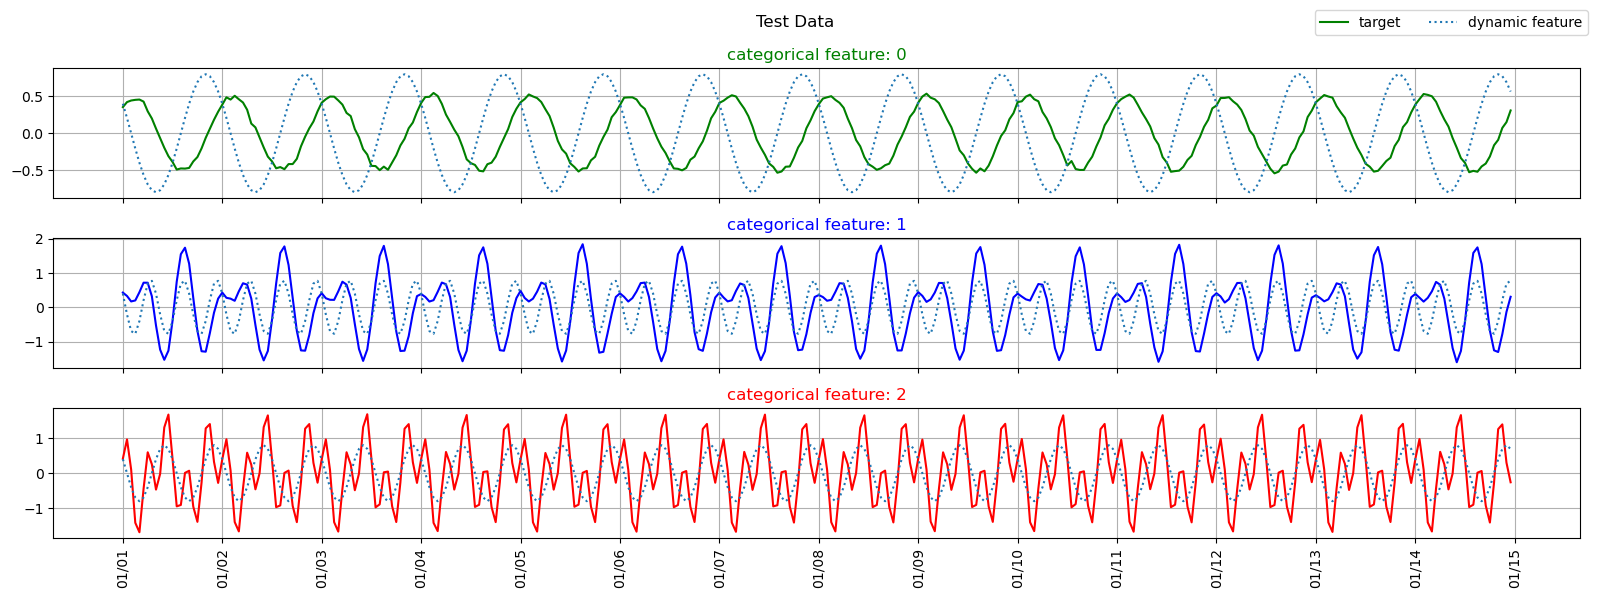

In [33]:
data = [synth_time_series(k) for k in range(NUMBER_OF_TS)]
targets_list = [df['target'] for df in data]
dynamic_feat_list = [df['dynamic_feat'] for df in data]
cat_list = [df['cat'] for df in data]

import matplotlib.dates as mdates

SAMPLES_LEN = 3

fig, ax = plt.subplots(SAMPLES_LEN, figsize=(16,6), sharex=True, constrained_layout=False)
for k in range(SAMPLES_LEN):
    cat_df = get_cat_df(k)
    ax[k].plot(targets_list[k], label="target", color=cat_df['color'])
    ax[k].plot(dynamic_feat_list[k], ls=":", label="dynamic feature")
    ax[k].set_title(f'categorical feature: {k % 3}', color=cat_df['color'])    
    ax[k].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    for label in ax[k].get_xticklabels(which='major'):
        label.set(rotation=90)  
    ax[k].grid(True)
    
lines = []
labels = []
line, label = ax[0].get_legend_handles_labels()
lines.extend(line) 
labels.extend(label)
fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), ncol=2)
fig.suptitle(f'Test Data')
fig.tight_layout()
plt.show()

Often one is interested in tuning or evaluating the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

In this example, we will leave out the last section of each of the time series we just generated and use only the first part as training data. Here we will predict `prediction length` data points, therefore we take out the trailing `prediction length` points from each time series to define the training set. The test set contains the full range of each time series.

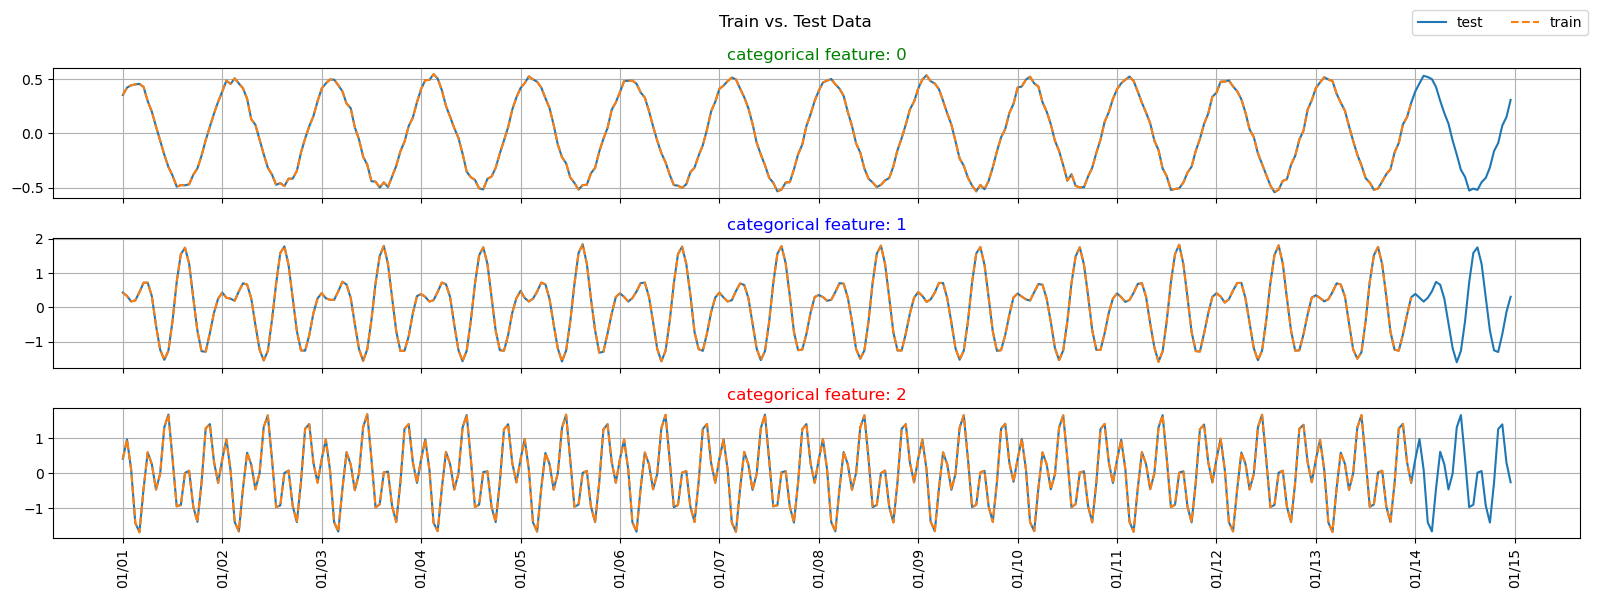

In [34]:
train_data = []
for targets in targets_list:
    train_data.append(targets[:-prediction_length])


fig, ax = plt.subplots(SAMPLES_LEN, figsize=(16,6), sharex=True, constrained_layout=False) 
for k in range(SAMPLES_LEN):
    cat = get_cat_df(k)
    ax[k].plot(targets_list[k], label="test")
    ax[k].plot(train_data[k], label="train", ls="--")
    ax[k].set_title(f'categorical feature: {k % 3}', color=cat['color'])
    # set the xaxis major ticks locator for every day and rotate the xtick labels by 90 degrees    
    ax[k].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    for label in ax[k].get_xticklabels(which='major'):
        label.set(rotation=90)
    ax[k].grid(True)
    
lines = []
labels = []
line, label = ax[0].get_legend_handles_labels()
lines.extend(line) 
labels.extend(label) 
fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), ncol=2)
fig.suptitle('Train vs. Test Data')
fig.tight_layout()
plt.show()

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [35]:
def series_to_obj(targets:pd.Series, cat:int=None, dynamic_features:pd.Series=None)->dict:
    obj = {
        "start": str(targets.index[0]), 
        "target": list(targets),
    }
    if cat is not None:
        obj["cat"] = [cat]
    if dynamic_features is not None:
        obj["dynamic_feat"] = [list(dynamic_features)]
    return obj


def series_to_jsonline(targets:pd.Series, cat:int=None, dynamic_features:pd.Series=None)->str:
    return json.dumps(series_to_obj(targets, cat, dynamic_features))

In [36]:
ENCODING = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"

with open(FILE_TRAIN, "wb") as f:
    for k in range(len(train_data)):
        ts = train_data[k]
        dynamic_features = dynamic_feat_list[k][:-prediction_length]
        category = k % len(categories_df)
        f.write(series_to_jsonline(ts, category, dynamic_features).encode(ENCODING))
        f.write("\n".encode(ENCODING))

with open(FILE_TEST, "wb") as f:
    for k in range(len(targets_list)):
        ts = targets_list[k]
        dynamic_features = dynamic_feat_list[k]
        category = k % len(categories_df)
        f.write(series_to_jsonline(ts, category, dynamic_features).encode(ENCODING))
        f.write("\n".encode(ENCODING))
        
s3 = boto3.client("s3")
s3.upload_file(FILE_TRAIN, bucket, PREFIX + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, PREFIX + "/data/test/" + FILE_TRAIN)

### Train a model

We can now define the estimator that will launch the training job.

Next we need to set some hyperparameters: for example, frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options such as number of epochs, batch size, and learning rate. Refer to the documentation for a full description of the available parameters.

In [37]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=f"s3://{s3_output_path}",
    use_spot_instances=True,
    max_run=60*10, # 10 minutes
    max_wait=60*10, # 10 minutes
)

hyperparameters = {
    "time_freq": FREQ,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "cardinality": [len(categories_df)], # number of unique categories (as oposed to default 'auto')
    "num_dynamic_feat": 1,  # number of dynamic features (as oposed to default 'auto')
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",  # "gaussian", "student-T"
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [38]:
from time import gmtime, strftime

data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}

job_name = f'jumpstart-example-deepar-{strftime("%Y-%m-%d-%H-%M-%S", gmtime())}'

# estimator.fit(inputs=data_channels, job_name = job_name)

If you already trained a model using a training job, you can just load it and save the training cost

In [33]:
# load a model from a training job named 'jumpstart-example-deepar-2024-03-22-15-37-18'
# estimator = sagemaker.estimator.Estimator.attach('jumpstart-example-deepar-2024-03-22-15-37-18')

### Hyper Tunning the DeepAr job

You can also let sagemaker runs multiple training jobs and pick the best generated model. This is a hyper tuning job.

In [39]:
from sagemaker.tuner import IntegerParameter, HyperparameterTuner, CategoricalParameter

hyperparameters = {
    "time_freq": FREQ,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "cardinality": [len(categories_df)], # number of unique categories (as oposed to default 'auto')
    "num_dynamic_feat": 1,  # number of dynamic features (as oposed to default 'auto')
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",  # "gaussian", "student-T"
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

# this parameters don't change between training jobs
static_hyperparameters = {
    "time_freq": FREQ,
    "prediction_length": str(prediction_length),
    "cardinality": [len(categories_df)], # number of unique categories (as oposed to default 'auto')
    "num_dynamic_feat": 1,  # number of dynamic features (as oposed to default 'auto')
    "likelihood": "gaussian",  # "gaussian", "student-T"
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05", 
    "early_stopping_patience": "10",
}
# this parameters change between training jobs
hyperparameter_ranges = {
    # "epochs": IntegerParameter(22, 28),
    # "context_length": CategoricalParameter([str(context_length), str(int(context_length*2)), str(context_length*3)]),
    # "num_cells": IntegerParameter(35, 40),
    "num_layers": IntegerParameter(2, 3),
}

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name="train:final_loss",
    hyperparameter_ranges=hyperparameter_ranges,
    strategy="Bayesian",
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type="Minimize",
    max_runtime_in_seconds=60*10, # 10 minutes
    base_tuning_job_name=job_name,
    early_stopping_type="Auto",
    hyperparameters_to_keep_static=static_hyperparameters,
    autotune=True
)
tuner.fit(inputs=data_channels, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................!


### Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note:** remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

Deploy an endpoint from a HPO tunning job

In [40]:
pred = tuner.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
)

# get the endpoint_name from pred
endpoint_name = pred.endpoint_name
print(endpoint_name)


2024-06-19 11:47:33 Starting - Preparing the instances for training
2024-06-19 11:47:33 Downloading - Downloading the training image
2024-06-19 11:47:33 Training - Training image download completed. Training in progress.
2024-06-19 11:47:33 Uploading - Uploading generated training model
2024-06-19 11:47:33 Completed - Training job completed
-----------!jumpstart-example-de-240619-1142-001-700aab19


Deploy an endpoint from an estimator training job

In [16]:
# if you already trained or tuned a model:
# job_name = 'jumpstart-example-de-240404-1149-001-5eb8e268'
# # estimator.latest_training_job.name

# endpoint_name = sagemaker_session.endpoint_from_job(
#     job_name=job_name,
#     initial_instance_count=1,
#     instance_type="ml.m4.xlarge",
#     image_uri=image_uri,
#     role=role,
# )
# print(endpoint_name)

-----------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [45]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def set_prediction_parameters(self, freq:str, prediction_length:int):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = FREQ
        self.prediction_length = prediction_length

    def predict(
        self, 
        ts_list:list[pd.Series], 
        cat_list:list[str]=None, 
        dynamic_features_list:list[pd.Series]=None, 
        encoding="utf-8", 
        num_samples=100, 
        quantiles=["0.1", "0.5", "0.9"], 
        content_type="application/json"
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts_list -- list of `pandas.Series` objects, the time series target values
        cat_list -- list of integers (default: None): stattic categories
        dynamic_features_list -- list of dynamic features contains a `pandas.Series` objects
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts_list]
        req = self.__encode_request(ts_list, cat_list, dynamic_features_list, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(
        self, 
        ts_list:list[pd.Series], 
        cat_list:list[str], 
        dynamic_features_list:list[pd.Series], 
        encoding:str, 
        num_samples:int, 
        quantiles:list[str]
    )->str:
        instances = [series_to_obj(ts_list[k], cat_list[k] if cat_list else None, dynamic_features_list[k] if dynamic_features_list else None) for k in range(len(ts_list))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response:str, prediction_times:list[pd.DatetimeIndex], encoding:str)->list:
        response_data = json.loads(response.decode(encoding))
        prediction_list = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            prediction_list.append(
                pd.DataFrame(data=response_data["predictions"][k]["quantiles"], index=prediction_index)
            )
        return prediction_list

predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(FREQ, prediction_length)

a utility to plot the forecast

In [60]:
def plot_predictions(prediction_list:list[pd.Series], actual_data:list[pd.Series], categories_list:list[int], hour_interval:int, save_image_seq:int = None):    
    fig, ax = plt.subplots(len(prediction_list), figsize=(16, max(5,len(prediction_list))), sharex=True, constrained_layout=False)
    for k in range(len(prediction_list)):   
        p10 = prediction_list[k]["0.1"]
        p90 = prediction_list[k]["0.9"]
        ax[k].plot(actual_data[k], label="test data")
        ax[k].fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
        ax[k].plot(prediction_list[k]["0.5"], label="prediction median")
        cat = categories_list[k]
        ax[k].set_title(f'cat: {cat}', color=get_cat_df(k)['color'])
        # set the xaxis major ticks locator for every day and rotate the xtick labels by 90 degrees    
        ax[k].xaxis.set_major_locator(mdates.DayLocator())
        ax[k].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H'))
        for label in ax[k].get_xticklabels(which='major'):
            label.set(rotation=90)
        # set xaxis minor ticks locator for every intrval hours
        ax[k].xaxis.set_minor_locator(mdates.HourLocator(interval=hour_interval))    
        ax[k].grid(True)

    lines = []
    labels = []
    line, label = ax[0].get_legend_handles_labels()
    lines.extend(line) 
    labels.extend(label)     
    fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), ncol=3)
    fig.suptitle('Test Data & Forecasted Data')
    fig.tight_layout()
    if save_image_seq is not None:
        plt.savefig(f'data/deepar_pred_{save_image_seq}.png')
    plt.show()

### Make Predictions

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

/tmp/ipykernel_2452/3558119668.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts_list]
/tmp/ipykernel_2452/3558119668.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_index = pd.date_range(


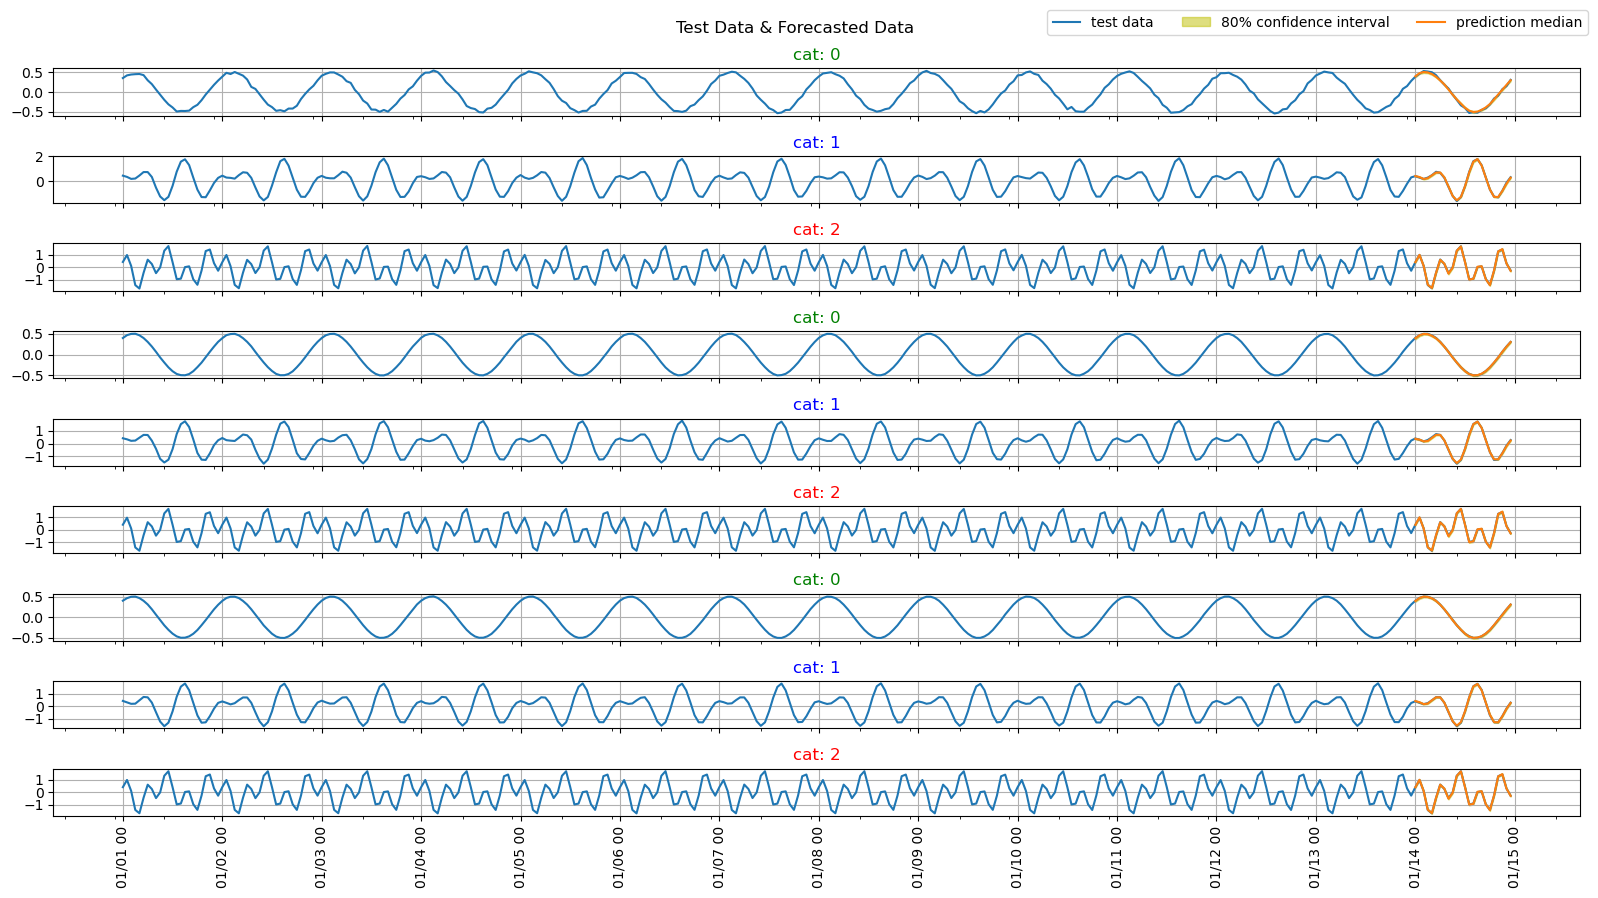

In [47]:
SAMPLES_TO_TEST = 9
FIRST_CATEGORY_TO_TEST = 0
idx = [x for x in range(FIRST_CATEGORY_TO_TEST, SAMPLES_TO_TEST, 1)]
ts_samples = [train_data[i] for i in idx]
dynamic_features_samples = [dynamic_feat_list[i] for i in idx]
categories_smaples = [i % len(categories_df) for i in idx]
actual_data = [targets_list[i] for i in idx]

predictions_list = predictor.predict(
    ts_list=ts_samples, 
    cat_list=categories_smaples, 
    dynamic_features_list=dynamic_features_samples, 
)

plot_predictions(predictions_list, actual_data, categories_smaples, 12)

### Predict new product

In case the given time series don't have a lot of historical data, we provide a small amount of data points. This could be a situation when the time series are generated from a new product. Is this example, we'll use a number smaller than the lengh of the predictions

/tmp/ipykernel_2452/3558119668.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts_list]
/tmp/ipykernel_2452/3558119668.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_index = pd.date_range(


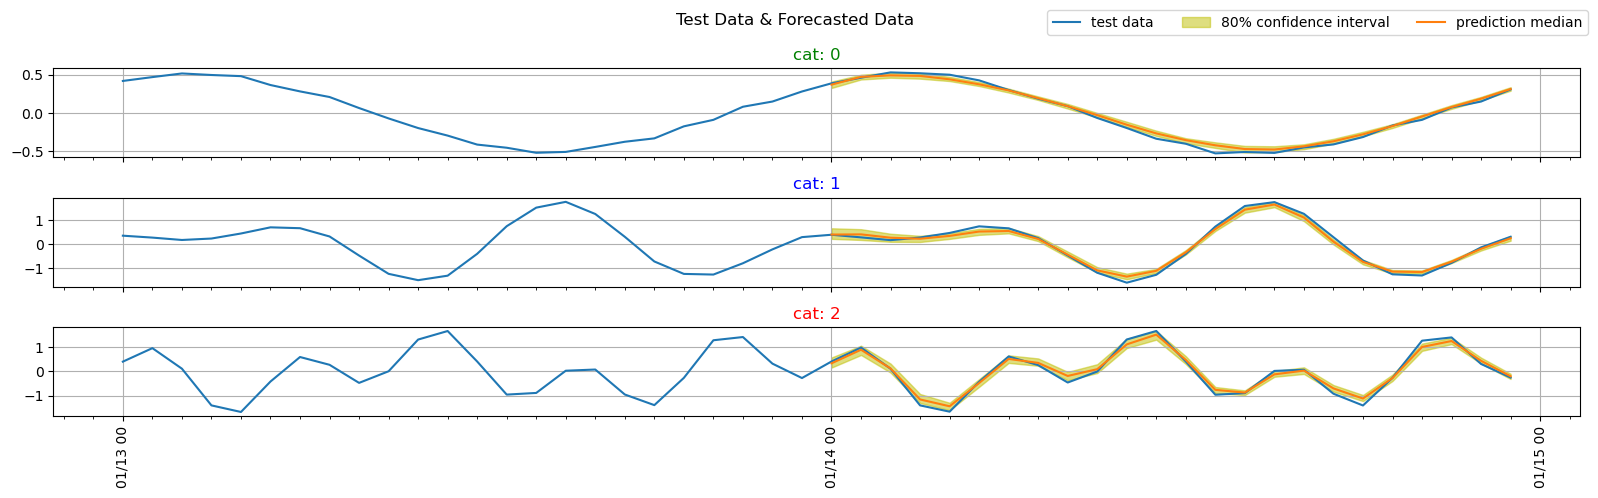

In [51]:
# Predict new products (use first NEW_SAMPLES_TO_TEST time series in training samples, using last NUM_OF_DATA_POINTS data points in each time series)
NEW_SAMPLES_TO_TEST = 3
FIRST_NEW_CATEGORY_TO_TEST = 0
NUM_OF_DATA_POINTS = 22

idx = [k for k in range(FIRST_NEW_CATEGORY_TO_TEST, NEW_SAMPLES_TO_TEST, 1)]
new_categories_smaples = [k % 3 for k in idx]
new_ts_samples = [train_data[k].iloc[-NUM_OF_DATA_POINTS:] for k in idx]
new_dynamic_features_samples = [dynamic_feat_list[k].iloc[-prediction_length-NUM_OF_DATA_POINTS:] for k in idx]
actual_data = [targets_list[k].iloc[-prediction_length-NUM_OF_DATA_POINTS:] for k in idx]

prediction_list = predictor.predict(
    ts_list=new_ts_samples, 
    cat_list=new_categories_smaples, 
    dynamic_features_list=new_dynamic_features_samples
)

plot_predictions(prediction_list, actual_data, new_categories_smaples, 1)
 

/tmp/ipykernel_2452/3558119668.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts_list]
/tmp/ipykernel_2452/3558119668.py:65: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_index = pd.date_range(


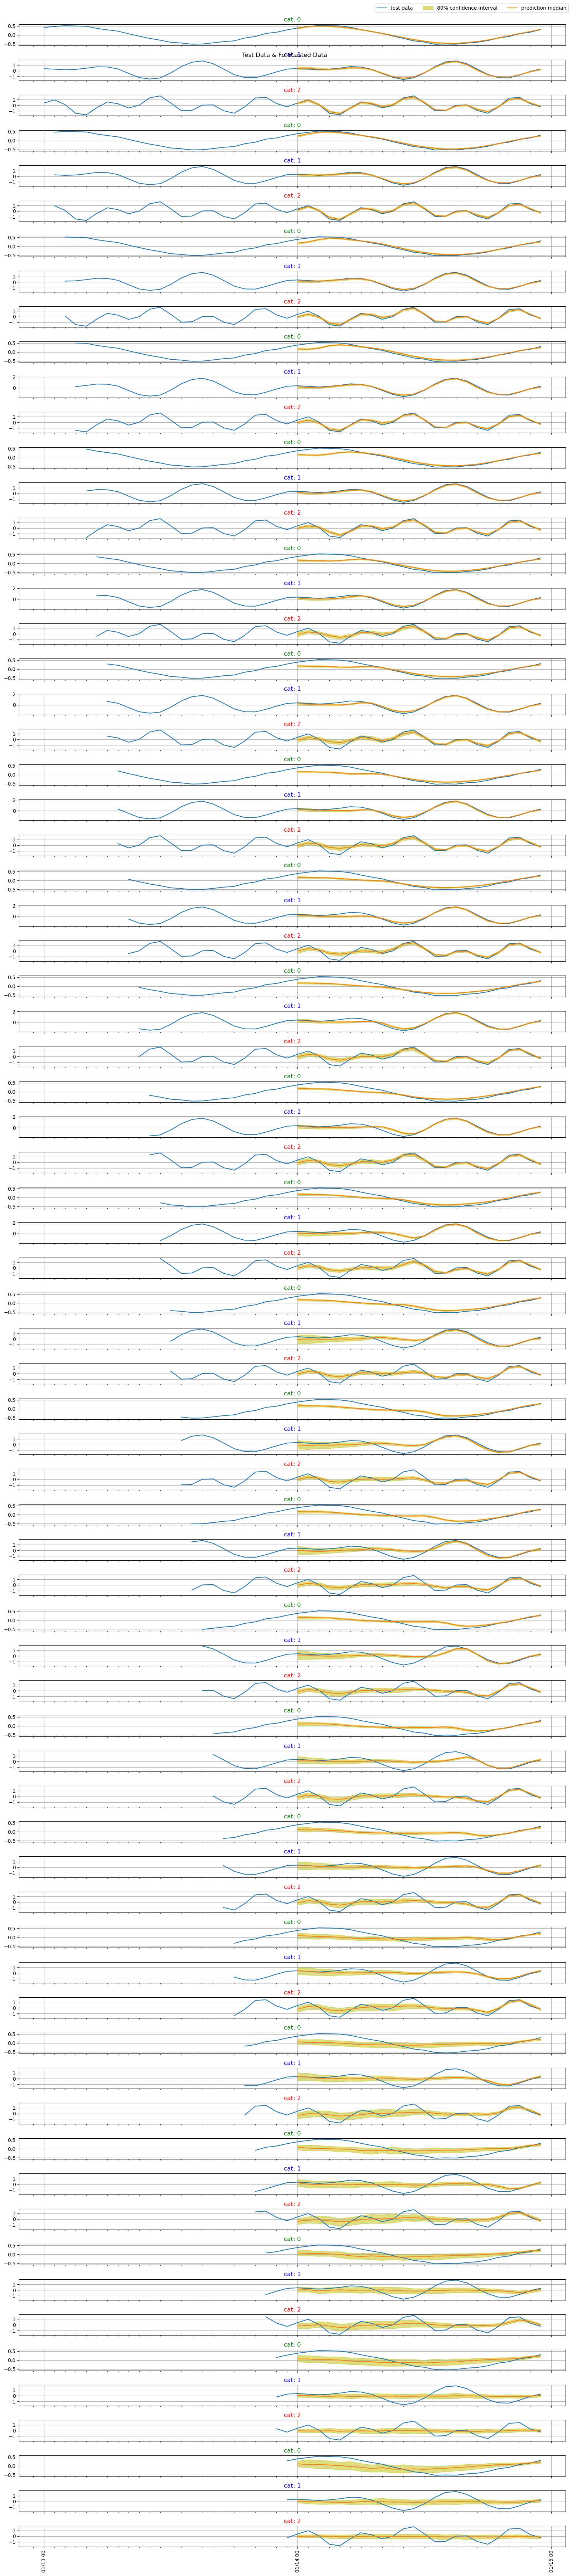

In [64]:
# Predict new products (using deacresing historic number of time series in training samples)
CATEGORY_TO_TEST = 0
INITIAL_NUM_OF_DATA_POINTS = 24
NEW_SAMPLES_TO_TEST = 3
FIRST_NEW_CATEGORY_TO_TEST = 0

new_categories_smaples = []
new_ts_samples = []
new_dynamic_features_samples = []
actual_data = []

for seq in range(INITIAL_NUM_OF_DATA_POINTS):   
    NUM_OF_DATA_POINTS = INITIAL_NUM_OF_DATA_POINTS-seq
    idx = [k for k in range(FIRST_NEW_CATEGORY_TO_TEST, NEW_SAMPLES_TO_TEST, 1)]    
    new_categories_smaples.extend([k % 3 for k in idx])
    new_ts_samples.extend([train_data[k].iloc[-NUM_OF_DATA_POINTS:] for k in idx])    
    new_dynamic_features_samples.extend([dynamic_feat_list[k].iloc[-prediction_length-NUM_OF_DATA_POINTS:] for k in idx])
    actual_data.extend([targets_list[k].iloc[-prediction_length-NUM_OF_DATA_POINTS:] for k in idx])

prediction_list = predictor.predict(
    ts_list=new_ts_samples, 
    cat_list=new_categories_smaples, 
    dynamic_features_list=new_dynamic_features_samples
)

plot_predictions(prediction_list, actual_data, new_categories_smaples, 1, 0)
    

### Delete endpoint

In [22]:
sagemaker_session.delete_endpoint(endpoint_name)